In [1]:
import subprocess
import configparser

import matplotlib.pyplot as plt
import pickle
import numpy as np
import os

if not os.path.isdir('./graphs'):
    os.makedirs('./graphs')

import math

#plt.style.use("ggplot")

class Trader:
    pass

class CustomUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if name == 'Trader':
            return Trader
        return super().find_class(module, name)

In [2]:
def plot_expectations(filename):
    data = CustomUnpickler(open(os.path.join('./output', filename),'rb')).load()  
    #trades = data['assets'][0].trades
    #print(len(trades))
    #print(sum([trade.buyer == trade.seller for trade in trades]))
    #fig, axs = plt.subplots(4, sharex=True, sharey=True)
    for i in range(0,4):
        names = []
        for j in range(0,4):
            agent = data['agents'][j]
            if(hasattr(agent, 'expectations')):
                expectations = agent.expectations
                plt.plot(expectations[:,0],expectations[:,i+1])
                names.append(agent.name)
        plt.ylabel('value')
        plt.xlabel('time')
        plt.legend(labels = names)
        titlestring = 'Agents\' view of suit '+str(i)+'\'s value over time'
        if i == data['goalsuit']:
            titlestring += " (GOAL SUIT)"
        plt.title(titlestring)
        plt.show()

In [3]:
#output is graph name, input_base is the file I want to input
def plot_rewards(input_base, iterations, output): 
    endcash = np.zeros([iterations,4])
    endpayout = np.zeros([iterations,4])
    avg_trades = 0
    for i in range(0, iterations):
        filename = os.path.join('./output',input_base+'.'+str(i)) 
        data = CustomUnpickler(open(filename, 'rb')).load()  
        cash = [agent.cash for agent in data['agents']]
        payout = [agent.payout for agent in data['agents']]
        names = [agent.name for agent in data['agents']]
        endcash[i,:] = cash
        endpayout[i,:] = payout
        avg_trades += sum([len(asset.trades) for asset in data["assets"]])/iterations
    cashmeans = np.mean(endcash,axis=0)
    payoutmeans = np.mean(endpayout,axis=0)
    print(cashmeans)
    cashstds  = np.std(endcash,axis=0)
    payoutstds  = np.std(endpayout,axis=0)
    print(payoutmeans)
    #print(endpayout)
    #print(payoutstds)

    fig, ax = plt.subplots()
    color = [agent.color for agent in data['agents']]
    ax.bar(range(0,4),cashmeans,color = color, edgecolor = "black")
    ax.errorbar(range(0,4), cashmeans, yerr = cashstds*2/math.sqrt(iterations),fmt="none", color="grey",capsize=5)
    ax.bar(range(0,4),payoutmeans,color = color,bottom=cashmeans, edgecolor = "black")
    ax.errorbar(range(0,4), payoutmeans+cashmeans, yerr=payoutstds*2/math.sqrt(iterations), fmt="none", color="black",capsize=5)
    ax.set_ylim((0,700))
    ax.set_ylabel("Mean cash + payout at end")
    ax.set_xlabel("Player")
    ax.set_xticks(range(0,4))
    ax.set_xticklabels(names)

    plt.show()
    fig.savefig('graphs/'+output+".png", facecolor='white', transparent=False)

# 2 Bottom Feeders

In [20]:
iterations=10
for i in range(1, 3):
    print(i)
    config = configparser.ConfigParser()
    config['fundamental'] = {'source': 'fundamentalist',
                             'n':i,
                             'cash': 350}
    prey = [k for k in range(0,i)]
    #prey = 0
    config['bottomfeeder'] = {'source': 'bottomfeeder_v2',
                              'n':2,
                              'cash': 350,
                              'params':{'prey': prey, 'ordersno': 4}}
    config['noisy'] = {'source': 'noise',
                       'n':4-i-2,
                       'cash': 350,
                       'params': '{\'var\': 1, \'horizon\': 50}'}
    with open('configs/temp_config.ini', 'w') as configfile:  #!!!
        config.write(configfile)
    for j in range(0, iterations):
        subprocess.run(['./market-des', '-r figgie -s 10000', '--index '+str(j),
               '--output '+'anna_2bfs.'+str(i), '--config '+"temp_config"],stdout=subprocess.DEVNULL)

1
2


In [5]:
data = CustomUnpickler(open(os.path.join('./output', 'anna_2bfs.1.0'),'rb')).load()

1
[515.24384289 371.31716104 379.98003536 133.45896071]
[33. 45. 65. 57.]


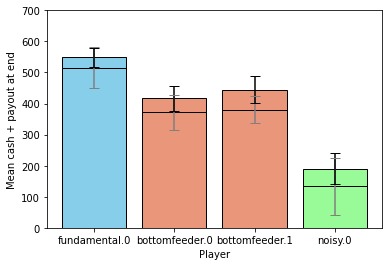

2
[347.28611221 247.80886746 378.7694333  426.13558703]
[77. 57. 44. 22.]


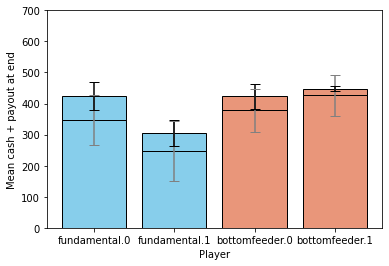

In [6]:
for i in range(1, 3):
    filename = 'anna_2bfs'+'.'+str(i) 
    print(i)
    plot_rewards(filename, iterations, filename)  

Why some approaching exp but some not?

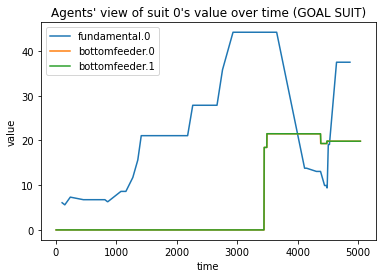

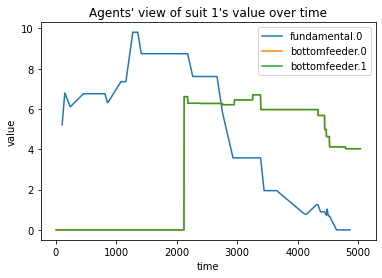

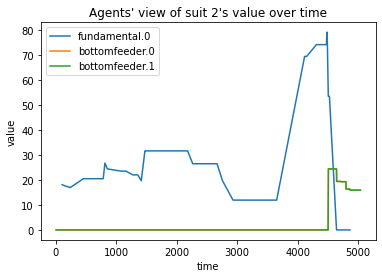

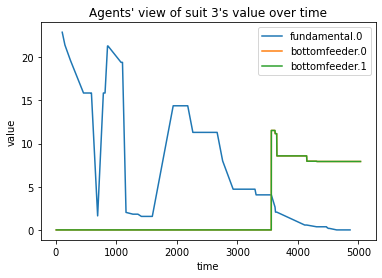

In [21]:
plot_expectations('anna_2bfs.1.1')

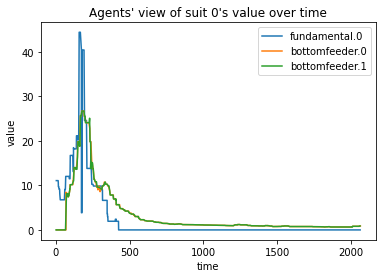

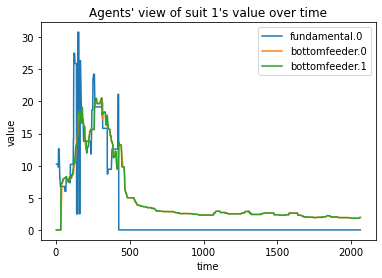

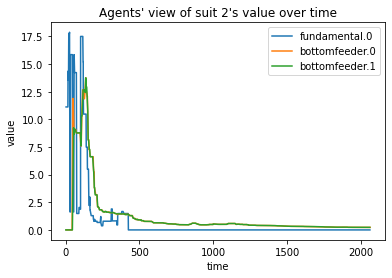

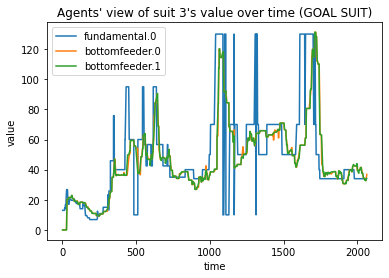

In [27]:
plot_expectations('anna_2bfs.1.8')

The reason why sometimes bottomfeeders do not approach fundamentalist's 0 expectation eponentially is that the fundamentalist is selling that suit with values higher than 0 in the market because others' are ordering them.

In [28]:
data_0 = CustomUnpickler(open(os.path.join('./output', 'anna_2bfs.1.8'),'rb')).load()

In [31]:
#analysis
i=0
for trade in data_0['assets'][1].trades:
    print(i, trade)
    i+=1
    
#See trades 132 (at 3.94) ,124 (at 4.39), and 117 (at 6.49), etc. Although the fundamentalist throught the value of suit 1 
#is 0 long before that (we need to figure out when), it still sold that suit to another 
#trader with a relatively high positive value.

0 noisy.0 bought 1 of 1 at 10.562707444515793 from fundamental.0
1 noisy.0 bought 1 of 1 at 9.860844669065214 from bottomfeeder.0
2 fundamental.0 bought 1 of 1 at 9.185177324282835 from noisy.0
3 noisy.0 bought 1 of 1 at 9.38058307728913 from noisy.0
4 fundamental.0 bought 1 of 1 at 9.46186361712548 from bottomfeeder.1
5 fundamental.0 bought 1 of 1 at 8.29710524916252 from noisy.0
6 fundamental.0 bought 1 of 1 at 8.767744231580375 from noisy.0
7 bottomfeeder.1 bought 1 of 1 at 8.587468969414612 from fundamental.0
8 bottomfeeder.0 bought 1 of 1 at 10.16379074192523 from bottomfeeder.1
9 fundamental.0 bought 1 of 1 at 10.804293742471723 from bottomfeeder.1
10 noisy.0 bought 1 of 1 at 11.275801287508468 from bottomfeeder.1
11 noisy.0 bought 1 of 1 at 8.570939646881671 from fundamental.0
12 fundamental.0 bought 1 of 1 at 11.410885551197628 from fundamental.0
13 noisy.0 bought 1 of 1 at 11.556585187465323 from fundamental.0
14 bottomfeeder.1 bought 1 of 1 at 12.011355791833735 from fundamen

In [32]:
i=0
for trade in data_0['assets'][2].trades:
    print(i, trade)
    i+=1
    
#here the price is much lower: trades 128 at 0.61, 119 at 0.66, etc.

0 fundamental.0 bought 1 of 2 at 7.508296864503273 from noisy.0
1 fundamental.0 bought 1 of 2 at 7.508296864503273 from noisy.0
2 noisy.0 bought 1 of 2 at 7.508296864503273 from fundamental.0
3 fundamental.0 bought 1 of 2 at 6.24120740914252 from noisy.0
4 fundamental.0 bought 1 of 2 at 5.671316530195214 from fundamental.0
5 noisy.0 bought 1 of 2 at 2.731760309633579 from fundamental.0
6 fundamental.0 bought 1 of 2 at 11.065706290561083 from noisy.0
7 bottomfeeder.1 bought 1.0 of 2 at 8.6059721282608 from fundamental.0
8 bottomfeeder.0 bought 1 of 2 at 10.678162714564396 from bottomfeeder.0
9 fundamental.0 bought 1 of 2 at 9.015442144641643 from fundamental.0
10 fundamental.0 bought 1 of 2 at 7.926201575303224 from fundamental.0
11 bottomfeeder.0 bought 1.0 of 2 at 7.6527648455276385 from fundamental.0
12 bottomfeeder.1 bought 1 of 2 at 7.017123275396805 from fundamental.0
13 noisy.0 bought 1 of 2 at 6.625370776955494 from bottomfeeder.1
14 noisy.0 bought 1 of 2 at 8.426601377208744 fr

In [40]:
num_bf=0
for trade in data_0['assets'][2].trades:
    if "bottomfeeder.0" in str(trade):
        num_bf+=1
num_bf

37

In [41]:
data_0['assets'][2].trades[0].time

25.69020613445888

## why the two Fundamentalists' expectations are opposite?

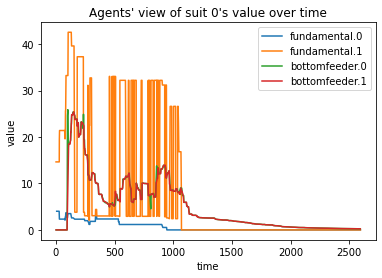

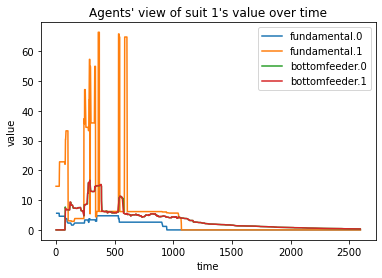

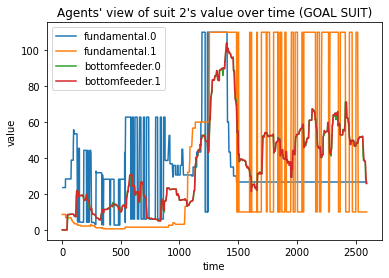

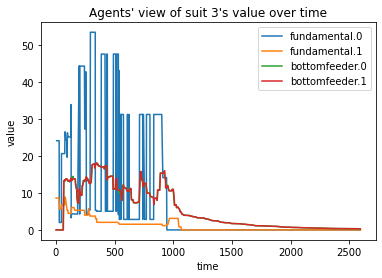

In [36]:
plot_expectations('anna_2bfs.2.1')

In [11]:
data = CustomUnpickler(open(os.path.join('./output', 'anna_2bfs.2.6'),'rb')).load()

In [33]:
for trade in data['assets'][2].trades:
    print(trade)

In [13]:
data = CustomUnpickler(open(os.path.join('./output', 'anna_2bfs.2.3'),'rb')).load()

In [14]:
for trade in data['assets'][1].trades:
    print(trade)

fundamental.1 bought 1 of 1 at 11.46953491451022 from fundamental.0
fundamental.1 bought 1 of 1 at 8.335253771056154 from fundamental.0
fundamental.1 bought 1 of 1 at 18.868565348309147 from bottomfeeder.0
fundamental.1 bought 1 of 1 at 20.139228906086302 from bottomfeeder.0
fundamental.1 bought 1.0 of 1 at 16.07178361214593 from fundamental.1
fundamental.1 bought 1.0 of 1 at 14.897094358767363 from fundamental.1
bottomfeeder.0 bought 1 of 1 at 14.531482445944988 from fundamental.1
fundamental.1 bought 1 of 1 at 20.317345238545702 from fundamental.1
fundamental.1 bought 1 of 1 at 18.963674713590795 from bottomfeeder.0
fundamental.1 bought 1 of 1 at 15.337638044641713 from fundamental.1
fundamental.1 bought 1.0 of 1 at 14.710754445094558 from fundamental.1
fundamental.1 bought 1.0 of 1 at 14.529631137457981 from fundamental.1
fundamental.1 bought 1.0 of 1 at 14.369371510244328 from fundamental.1
bottomfeeder.1 bought 1 of 1 at 13.05897157215276 from fundamental.1
fundamental.1 bought 1 

In [15]:
for i in range(4):
    print(data['agents'][i].name)

fundamental.0
fundamental.1
bottomfeeder.0
bottomfeeder.1


In [16]:
num_buy=0
num_sell=0
for order in data['agents'][3].orders:
    if order.buy:
        num_buy+=1 
    else:
        num_sell+=1
    print(order)

bottomfeeder.1 sell 1 of 3 at 30.643106732987235
bottomfeeder.1 buy 1.0 of 1 at 4.252950454227366
bottomfeeder.1 buy 1 of 3 at 8.986839732330836
bottomfeeder.1 sell 1 of 2 at 30.702806832935302
bottomfeeder.1 buy 1.0 of 0 at 19.743338017647112
bottomfeeder.1 sell 1 of 2 at 42.68434783052674
bottomfeeder.1 sell 1 of 2 at 48.53463263187056
bottomfeeder.1 sell 1 of 1 at 27.185237200846053
bottomfeeder.1 buy 1.0 of 0 at 14.063612175530189
bottomfeeder.1 buy 1 of 2 at 14.166754582154041
bottomfeeder.1 sell 1 of 1 at 39.30937193448825
bottomfeeder.1 sell 1 of 0 at 21.037089088390637
bottomfeeder.1 buy 1.0 of 0 at 17.188218740856694
bottomfeeder.1 buy 1 of 2 at 2.0563254343119826
bottomfeeder.1 buy 1 of 0 at 3.7808391166120185
bottomfeeder.1 sell 1 of 1 at 25.31389672291164
bottomfeeder.1 sell 1 of 2 at 18.18579801390148
bottomfeeder.1 buy 1 of 1 at 2.744938095575106
bottomfeeder.1 sell 1 of 0 at 18.377108812246355
bottomfeeder.1 buy 1 of 1 at 13.05897157215276
bottomfeeder.1 buy 1 of 3 at 2.

bottomfeeder.1 buy 1 of 0 at 0.010263364995073593
bottomfeeder.1 buy 1 of 2 at 0.06904544135894924
bottomfeeder.1 buy 1 of 3 at 40.44104839705764
bottomfeeder.1 buy 1 of 3 at 23.201905992469793
bottomfeeder.1 buy 1 of 3 at 12.846059619259393
bottomfeeder.1 sell 1 of 1 at 0.6258415007160086
bottomfeeder.1 buy 1 of 3 at 47.8368455337914
bottomfeeder.1 buy 1 of 3 at 47.873518997411615
bottomfeeder.1 buy 1 of 3 at 27.261103434647566
bottomfeeder.1 sell 1 of 1 at 0.5821170667986486
bottomfeeder.1 sell 1 of 2 at 0.1361287000622221
bottomfeeder.1 sell 1 of 0 at 0.3218983977904703
bottomfeeder.1 sell 1 of 1 at 0.573580039651196
bottomfeeder.1 sell 1 of 0 at 0.30300815793038066
bottomfeeder.1 sell 1 of 1 at 0.5593574141522866
bottomfeeder.1 buy 1 of 1 at 0.2408859541803926
bottomfeeder.1 sell 1 of 2 at 0.13357060724844114
bottomfeeder.1 sell 1 of 1 at 0.5427986961412753
bottomfeeder.1 buy 1 of 3 at 43.56264445349807
bottomfeeder.1 buy 1 of 0 at 0.13426085164182786
bottomfeeder.1 buy 1 of 1 at 0

In [17]:
num_buy,num_sell

(217, 222)

In [18]:
data['agents'][0].cash

413.7768800302331

In [19]:
#     orders = data['agents'][0].orders
#     orders = [order for order in orders if order.assetno == 0]
#     order_prices = [order.price for order in orders]
#     colors = ["red" if order.buy else "green" for order in orders]
#     plt.scatter(range(0,len(orders)),order_prices,color = colors)
#     plt.show()